In [2]:
using MLJ
using CSV
using DataFrames

Load the Fisher Iris dataset

In [3]:
OpenML.describe_dataset(61)

**Author**: R.A. Fisher   **Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/Iris) - 1936 - Donated by Michael Marshall   **Please cite**:   

**Iris Plants Database**   This is perhaps the best known database to be found in the pattern recognition literature.  Fisher's paper is a classic in the field and is referenced frequently to this day.  (See Duda & Hart, for example.)  The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant.  One class is     linearly separable from the other 2; the latter are NOT linearly separable from each other.

Predicted attribute: class of iris plant.   This is an exceedingly simple domain.  

### Attribute Information:

```
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm
5. class: 
   -- Iris Setosa
   -- Iris Versicolour
   -- Iris Virginica
```


In [4]:
iris = OpenML.load(61);
iris = DataFrame(iris); 
first(iris, 4)

,sepallength,sepalwidth,petallength,petalwidth,class
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa


**Goal**: Build a model to predcit the `:class` variable given the rest

In [5]:
schema(iris)

┌─────────────┬──────────────────────────────────┬───────────────┐
│ _.names     │ _.types                          │ _.scitypes    │
├─────────────┼──────────────────────────────────┼───────────────┤
│ sepallength │ Float64                          │ Continuous    │
│ sepalwidth  │ Float64                          │ Continuous    │
│ petallength │ Float64                          │ Continuous    │
│ petalwidth  │ Float64                          │ Continuous    │
│ class       │ CategoricalValue{String, UInt32} │ Multiclass{3} │
└─────────────┴──────────────────────────────────┴───────────────┘
_.nrows = 150


In [6]:
# get rid of any missing values
coerce!(iris,
        Union{Missing,Continuous}=>Continuous,
        Union{Missing,Multiclass}=>Multiclass,
        tight=true)
schema(iris)

┌─────────────┬──────────────────────────────────┬───────────────┐
│ _.names     │ _.types                          │ _.scitypes    │
├─────────────┼──────────────────────────────────┼───────────────┤
│ sepallength │ Float64                          │ Continuous    │
│ sepalwidth  │ Float64                          │ Continuous    │
│ petallength │ Float64                          │ Continuous    │
│ petalwidth  │ Float64                          │ Continuous    │
│ class       │ CategoricalValue{String, UInt32} │ Multiclass{3} │
└─────────────┴──────────────────────────────────┴───────────────┘
_.nrows = 150


# Split data into input and target pairs

In [7]:
y, X = unpack(iris, ==(:class), name->true, rng=42);

In [8]:
scitype(y)

AbstractVector{Multiclass{3}} (alias for AbstractArray{Multiclass{3}, 1})

# Searching for a model 

In [10]:
filter_julia_classifiers(meta) = AbstractVector{Finite} <: meta.target_scitype && meta.is_pure_julia

models(filter_julia_classifiers)

21-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = BetaML, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

Find all models with "Classifier" in their name or docstring

In [11]:
models("Classifier")

45-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BernoulliNBClassifier, package_name = ScikitLearn, ... )
 (name = ComplementNBClassifier, package_name = ScikitLearn, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = BetaML, 

Better yet, let's find all models that match our data! 

In [14]:
models(matching(X, y))

47-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name

# Select and instantiate a model

In [16]:
using Pkg
Pkg.add("MLJFlux")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed DiffRules ─ v1.8.0
    Updating `~/gitRepos/ml-demos/Project.toml`
  [094fc8d1] + MLJFlux v0.2.5
    Updating `~/gitRepos/ml-demos/Manifest.toml`
  [621f4979] + AbstractFFTs v1.0.1
  [1520ce14] + AbstractTrees v0.3.4
  [4fba245c] + ArrayInterface v3.2.1
  [ab4f0b2a] + BFloat16s v0.2.0
  [fa961155] + CEnum v0.4.1
  [052768ef] + CUDA v3.5.0
  [082447d4] + ChainRules v1.16.0
  [bbf7d656] + CommonSubexpressions v0.3.0
  [163ba53b] + DiffResults v1.0.3
  [b552c78f] + DiffRules v1.8.0
  [e2ba6199] + ExprTools v0.1.6
  [587475ba] + Flux v0.12.8
  [f6369f11] + ForwardDiff v0.10.23
  [d9f16b24] + Functors v0.2.7
  [0c68f7d7] + GPUArrays v8.1.2
  [61eb1bfa] + GPUCompiler v0.13.9
  [7869d1d1] + IRTools v0.4.4
  [615f187c] + IfElse v0.1.1
  [e5e0dc1b] + Juno v0.8.4
  [929cbde3] + LLVM v4.7.0
  [094fc8d1] + MLJFlux v0.2.5
  [e89f7d12] + Media v0.5.0
  [872c559c] + NNlib v0.7.31
  [a00861dc] + N

In [19]:
# load a model

NeuralNetworkClassifier = @load NeuralNetworkClassifier

import MLJFlux ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/john/.julia/packages/MLJModels/GKDnU/src/loading.jl:168


MLJFlux.NeuralNetworkClassifier

In [20]:
# instantiate the model 
model = NeuralNetworkClassifier()

NeuralNetworkClassifier(
    builder = Short(
            n_hidden = 0,
            dropout = 0.5,
            σ = NNlib.σ),
    finaliser = NNlib.softmax,
    optimiser = Flux.Optimise.ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}()),
    loss = Flux.Losses.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    rng = Random._GLOBAL_RNG(),
    optimiser_changes_trigger_retraining = false,
    acceleration = CPU1{Nothing}(nothing))

In [21]:
info(model)

A neural network model for making probabilistic predictions of a `Multiclass` or `OrderedFactor` target, given a table of `Continuous` features. 
→ based on [MLJFlux](https://github.com/alan-turing-institute/MLJFlux.jl).
→ do `@load NeuralNetworkClassifier pkg="MLJFlux"` to use the model.
→ do `?NeuralNetworkClassifier` for documentation.
(name = "NeuralNetworkClassifier",
 package_name = "MLJFlux",
 is_supervised = true,
 abstract_type = Probabilistic,
 deep_properties = (:optimiser, :builder),
 docstring = "A neural network model for making probabilistic predictions of a `Multiclass` or `OrderedFactor` target, given a table of `Continuous` features. \n→ based on [MLJFlux](https://github.com/alan-turing-institute/MLJFlux.jl).\n→ do `@load NeuralNetworkClassifier pkg=\"MLJFlux\"` to use the model.\n→ do `?NeuralNetworkClassifier` for documentation.",
 fit_data_scitype = Tuple{Table{<:AbstractVector{<:Continuous}}, AbstractVector{<:Finite}},
 hyperparameter_ranges = (nothing, nothing, n

An MLJ model is just a mutable struct holding hyperparameters. 

In [22]:
model.epochs = 12

12

# Fitting, predicting, and inspecting models

in MLJ, model training/validation are bound together in a `machine()`. 

In [23]:
mach = machine(model, X, y)

Machine{NeuralNetworkClassifier{Short,…},…} trained 0 times; caches data
  args: 
    1:	Source @309 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @384 ⏎ `AbstractVector{Multiclass{3}}`


A `machine` stores the *learned* parameters. 

Let's train our machine on 70% of the data and evaluate on a holdout set with 30%. 

In [25]:
train, test = partition(eachindex(y), 0.7, shuffle=true) # produce indices for train/test split

([84, 30, 106, 7, 133, 114, 134, 42, 23, 136  …  59, 78, 98, 104, 9, 29, 119, 13, 20, 12], [3, 83, 56, 95, 34, 41, 127, 87, 25, 66  …  38, 61, 122, 27, 39, 22, 123, 113, 146, 28])

Now we can `fit!`

In [26]:
fit!(mach, rows=train, verbosity=2)

┌ Info: Training Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
┌ Info: Loss is 1.644
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.56
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.42
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.254
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.235
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.192
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.095
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.152
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.122
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.154
└ @ MLJFlux /home/john/.ju

Machine{NeuralNetworkClassifier{Short,…},…} trained 1 time; caches data
  args: 
    1:	Source @309 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @384 ⏎ `AbstractVector{Multiclass{3}}`


And we can `predict` via

In [28]:
ŷ = predict(mach, rows=test)
ŷ[1:3]

3-element MLJBase.UnivariateFiniteVector{Multiclass{3}, String, UInt32, Float64}:
 UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.288, Iris-versicolor=>0.341, Iris-virginica=>0.371)
 UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.287, Iris-versicolor=>0.343, Iris-virginica=>0.37)
 UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.292, Iris-versicolor=>0.32, Iris-virginica=>0.388)

or

In [31]:
ŷ = predict(mach, X[test, :])
ŷ[1:3]

3-element MLJBase.UnivariateFiniteVector{Multiclass{3}, String, UInt32, Float64}:
 UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.288, Iris-versicolor=>0.341, Iris-virginica=>0.371)
 UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.287, Iris-versicolor=>0.343, Iris-virginica=>0.37)
 UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.292, Iris-versicolor=>0.32, Iris-virginica=>0.388)

now that our machine is fitted, we can inspect the learned parameters

In [32]:
fitted_params(mach)  # see which params were fitted

(chain = Chain(Chain(Dense(4, 3, σ), Dropout(0.5), Dense(3, 3)), softmax),)

In [33]:
report(mach)  # print per epoch loss

(training_losses = [1.4336826726115968, 1.6440542862286258, 1.5598450015697154, 1.420427569690476, 1.2537524057177758, 1.2348144041287794, 1.1916801438063866, 1.0948763132600585, 1.1517034759247204, 1.1215142027848028, 1.1543581231737337, 1.1367435105804533, 1.1261994034873632],)

Save a model via 

In [34]:
MLJ.save("neural_net.jlso", mach)

Retrieve a model via

In [36]:
mach2 = machine("neural_net.jlso")

Machine{NeuralNetworkClassifier{Short,…},…} trained 1 time; caches data
  args: 


we can now use our loaded model to make predictions

In [37]:
ŷ = predict(mach2, X)
ŷ[1:3]

3-element MLJBase.UnivariateFiniteVector{Multiclass{3}, String, UInt32, Float64}:
 UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.291, Iris-versicolor=>0.322, Iris-virginica=>0.387)
 UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.291, Iris-versicolor=>0.328, Iris-virginica=>0.381)
 UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.288, Iris-versicolor=>0.341, Iris-virginica=>0.371)

to continue fitting a saved model, you must bind some data to it:

In [38]:
mach3 = machine("neural_net.jlso", X, y)
fit!(mach3)

┌ Info: Training Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
Optimising neural net:100%[=========================] Time: 0:00:00


Machine{NeuralNetworkClassifier{Short,…},…} trained 2 times; caches data
  args: 
    1:	Source @889 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @686 ⏎ `AbstractVector{Multiclass{3}}`


we can perform a warm-restart (i.e. continue where we left off) by increasing the iteration parameter:

In [39]:
model.epochs = model.epochs + 4 

16

In [40]:
fit!(mach, rows=train, verbosity=2)

┌ Info: Updating Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:404
┌ Info: Loss is 1.116
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.114
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.137
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.113
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128


Machine{NeuralNetworkClassifier{Short,…},…} trained 2 times; caches data
  args: 
    1:	Source @309 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @384 ⏎ `AbstractVector{Multiclass{3}}`


For a NN we can increase the `:learning_rate` without triggering a full restart

In [41]:
model.epochs = model.epochs + 4 
model.optimiser.eta = 10*model.optimiser.eta
fit!(mach, rows=train, verbosity=2)

┌ Info: Updating Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:404
┌ Info: Loss is 1.096
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.118
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.104
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.069
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128


Machine{NeuralNetworkClassifier{Short,…},…} trained 3 times; caches data
  args: 
    1:	Source @309 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @384 ⏎ `AbstractVector{Multiclass{3}}`


changing any other hyperparameter will cause it to retrain from scratch 

In [42]:
model.lambda = 0.001
fit!(mach, rows=train, verbosity=2)

┌ Info: Updating Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:404
┌ Info: Loss is 1.243
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.016
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.8939
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.936
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.8384
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.7969
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.7961
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.8009
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.7878
└ @ MLJFlux /home/john/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.7648
└ @ MLJFlux /home

Machine{NeuralNetworkClassifier{Short,…},…} trained 4 times; caches data
  args: 
    1:	Source @309 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @384 ⏎ `AbstractVector{Multiclass{3}}`


Let's try training for a while longer 

In [43]:
model.epochs = 50
fit!(mach, rows=train)
yhat = predict(mach, X[test,:]); # or predict(mach, rows=test)
yhat[1]

┌ Info: Updating Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:404
Optimising neural net:100%[=========================] Time: 0:00:01


UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.00967, Iris-versicolor=>0.352, Iris-virginica=>0.639)

In [44]:
info(model).prediction_type

:probabilistic

we have many options for probabilistic models. Let's try some out: 

In [46]:
yhat[1]

UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.00967, Iris-versicolor=>0.352, Iris-virginica=>0.639)

In [45]:
pdf(yhat[1], "Iris-virginica")

0.638565438150432

get the most likely value via `mode()`

In [47]:
mode(yhat[1])

CategoricalArrays.CategoricalValue{String, UInt32} "Iris-virginica"

we can broadcast these operations 

In [48]:
pdf.(yhat, "Iris-virginica")

45-element Vector{Float64}:
 0.638565438150432
 0.026398091009350293
 0.4731448025661525
 0.028661296592622225
 0.02387264457526202
 0.025578062012357478
 0.027718761407639916
 0.7775105564941073
 0.7028058978446596
 0.2193457062515473
 0.6711350744581164
 0.02549231351613363
 0.216710803640492
 ⋮
 0.2862547703636074
 0.2521823151120664
 0.2447678292213899
 0.2854750658679641
 0.03545116929438963
 0.20538838233744883
 0.33173441741312554
 0.24000902178038022
 0.3022091532324718
 0.5676189928229167
 0.23074589352974542
 0.025716434070151593

In [49]:
mode.(yhat)

45-element CategoricalArrays.CategoricalArray{String,1,UInt32}:
 "Iris-virginica"
 "Iris-setosa"
 "Iris-versicolor"
 "Iris-setosa"
 "Iris-setosa"
 "Iris-setosa"
 "Iris-setosa"
 "Iris-virginica"
 "Iris-virginica"
 "Iris-versicolor"
 "Iris-virginica"
 "Iris-setosa"
 "Iris-versicolor"
 ⋮
 "Iris-versicolor"
 "Iris-versicolor"
 "Iris-versicolor"
 "Iris-versicolor"
 "Iris-setosa"
 "Iris-versicolor"
 "Iris-versicolor"
 "Iris-versicolor"
 "Iris-versicolor"
 "Iris-virginica"
 "Iris-versicolor"
 "Iris-setosa"

Alternatively, `predict_mode()` will give the predicted class 

In [50]:
predict_mode(mach, X[test,:])[1:4]

4-element CategoricalArrays.CategoricalArray{String,1,UInt32}:
 "Iris-virginica"
 "Iris-setosa"
 "Iris-versicolor"
 "Iris-setosa"

# Evaluate the model performance

MLJ has a handy routine to do the model evaluation.

In [52]:
evaluate!(mach, resampling=Holdout(fraction_train=0.7),
    measures=[cross_entropy, brier_score]
)

PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────────┬─────────────┬───────────┬──────────┐
│ measure                    │ measurement │ operation │ per_fold │
├────────────────────────────┼─────────────┼───────────┼──────────┤
│ LogLoss(tol = 2.22045e-16) │ 0.399       │ predict   │ [0.399]  │
│ BrierScore()               │ -0.207      │ predict   │ [-0.207] │
└────────────────────────────┴─────────────┴───────────┴──────────┘


we can apply cross-validation instead: 

In [53]:
evaluate!(mach, resampling=CV(nfolds=6),
    measures=[cross_entropy, brier_score]
)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:16


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────────┬─────────────┬───────────┬────────────────────────
│ measure                    │ measurement │ operation │ per_fold              ⋯
├────────────────────────────┼─────────────┼───────────┼────────────────────────
│ LogLoss(tol = 2.22045e-16) │ 0.415       │ predict   │ [0.31, 0.452, 0.467,  ⋯
│ BrierScore()               │ -0.227      │ predict   │ [-0.165, -0.251, -0.2 ⋯
└────────────────────────────┴─────────────┴───────────┴────────────────────────
                                                                1 column omitted


we can also use Monte Carlo cross-validation (e.g. with repeated randomized folds) 

In [54]:
e = evaluate!(mach, resampling=CV(nfolds=6, rng=123),
              repeats=3,
              measures=[cross_entropy, brier_score])

Evaluating over 18 folds: 100%[=========================] Time: 0:00:46


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────────┬─────────────┬───────────┬────────────────────────
│ measure                    │ measurement │ operation │ per_fold              ⋯
├────────────────────────────┼─────────────┼───────────┼────────────────────────
│ LogLoss(tol = 2.22045e-16) │ 0.42        │ predict   │ [0.504, 0.43, 0.326,  ⋯
│ BrierScore()               │ -0.237      │ predict   │ [-0.308, -0.232, -0.1 ⋯
└────────────────────────────┴─────────────┴───────────┴────────────────────────
                                                                1 column omitted


`e` now has a number of properties we can inspect including `measure`, `measurement`, `per_fold`, and `per_observation`

In [63]:
logloss = e.per_fold[1]
println("logloss= ", mean(logloss), " ± ", std(logloss))
brier = e.per_fold[2]
println("brierscore= ", mean(brier), " ± ", std(brier))

logloss= 0.41986513758286786 ± 0.06959214904530305
brierscore= -0.23687596670543856 ± 0.04708818105209173


We can also restrict `evaluate()` to only the training rows if you want:

In [64]:
train, test = partition(eachindex(y), 0.7)
mach = machine(model, X, y)
evaluate!(mach, resampling=CV(nfolds=6),
          measures=[cross_entropy, brier_score],
          rows=train)     # cv estimate, resampling from `train`

┌ Info: Creating subsamples from a subset of all rows. 
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/resampling.jl:490
Evaluating over 6 folds: 100%[=========================] Time: 0:00:11


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────────┬─────────────┬───────────┬────────────────────────
│ measure                    │ measurement │ operation │ per_fold              ⋯
├────────────────────────────┼─────────────┼───────────┼────────────────────────
│ LogLoss(tol = 2.22045e-16) │ 0.414       │ predict   │ [0.375, 0.347, 0.462, ⋯
│ BrierScore()               │ -0.231      │ predict   │ [-0.201, -0.185, -0.2 ⋯
└────────────────────────────┴─────────────┴───────────┴────────────────────────
                                                                1 column omitted


In [65]:
fit!(mach, rows=train)    # re-train using all of `train` observations

┌ Info: Training Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
Optimising neural net:100%[=========================] Time: 0:00:02


Machine{NeuralNetworkClassifier{Short,…},…} trained 7 times; caches data
  args: 
    1:	Source @458 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @955 ⏎ `AbstractVector{Multiclass{3}}`


In [68]:
predict(mach, rows=test); # and predict missing targets

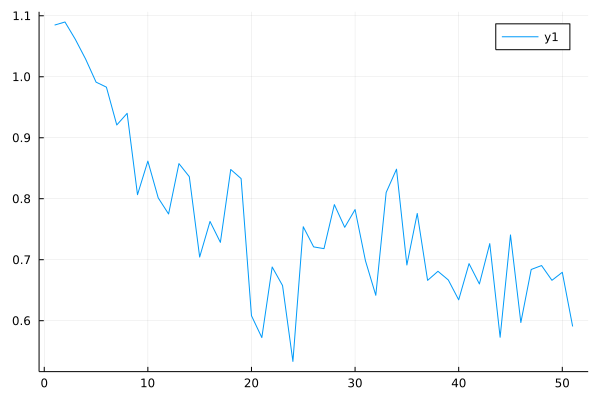

In [85]:
plot(report(mach).training_losses)

# Learning Curves

In [86]:
r = range(model, :epochs, lower=1, upper=50)

NumericRange(1 ≤ epochs ≤ 50; origin=25.5, unit=24.5)

In [90]:
curve = learning_curve(mach,
                       range=r,
                       resampling=Holdout(fraction_train=0.7), # (default)
                       measure=cross_entropy)


┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
┌ Info: Attempting to evaluate 30 models.
└ @ MLJTuning /home/john/.julia/packages/MLJTuning/bjRHJ/src/tuned_models.jl:680
Evaluating over 30 metamodels: 100%[=========================] Time: 0:00:02


(parameter_name = "epochs",
 parameter_scale = :linear,
 parameter_values = [1, 3, 4, 6, 8, 9, 11, 13, 15, 16  …  35, 36, 38, 40, 42, 43, 45, 47, 48, 50],
 measurements = [0.9642334968383826, 0.7611330568962873, 0.7020568931803699, 0.632943642719447, 0.6169772135379632, 0.5928938750629911, 0.5644106692422063, 0.5619940401803774, 0.571280115615697, 0.5638080939491867  …  0.44223591588036054, 0.43066961955183003, 0.4555875545087298, 0.41438433156376586, 0.3912311905665708, 0.4119545819959012, 0.428914801843594, 0.4264896038319531, 0.4099500504910243, 0.4021205125391061],)

In [88]:
using Plots

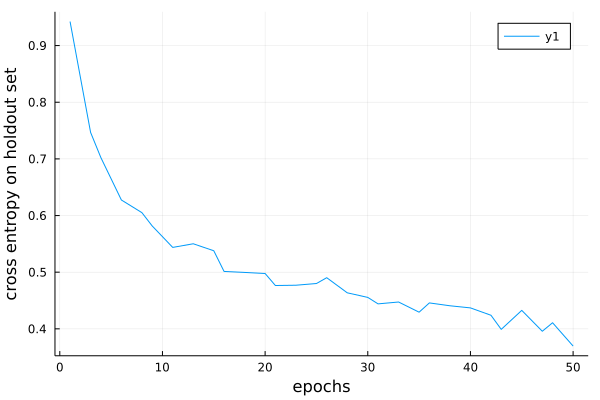

In [89]:
plot(curve.parameter_values, curve.measurements)
xlabel!("epochs")
ylabel!("cross entropy on holdout set")

# Summary: 

- `evaluate!()` let's you see the results of a model evaluated with different resampling schemes against desired metrics
- `evaluate()` does not fit the model 
- First use evaluate to see if fitting will work, then fit the final model. 